# Loading and saving the dataset

In [18]:
from datasets import load_dataset

# Load dataset from huggingface
dataset = load_dataset("Micol/musical-instruments-sound-dataset")

In [19]:
# Optional -> save to disk to prevent re-download
# dataset.save_to_disk("data/")

---------
# Dataset preprocessing

In [20]:
import torch
from torchaudio.transforms import MelSpectrogram, Resample
from torch.utils.data import DataLoader, Dataset as TorchDataset

In [21]:
# Define a custom PyTorch Dataset for pre-processing
class AudioDataset(TorchDataset):
    # I've previously used 16000Hz as sr, which was the lowest of the dataset, maybe it wasn't a good idea, since we can re-sample up to.
    def __init__(self, dataset, target_sr=44100, fixed_duration=2):  # Fixed duration is now 2 seconds
        """
        Custom PyTorch Dataset for audio classification.
        
        Args:
            dataset: Hugging Face dataset containing 'audio' and 'label' columns.
            target_sr: Target sampling rate to resample all audio.
            fixed_duration: Fixed duration for all audio clips (in seconds).
        """
        self.dataset = dataset
        self.target_sr = target_sr
        self.num_samples = target_sr * fixed_duration

        # Mel Spectrogram transform
        self.mel_transform = MelSpectrogram(
            sample_rate=target_sr, 
            n_fft=1024, 
            hop_length=512, 
            n_mels=64
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load audio and label
        audio_array = self.dataset[idx]['audio']['array']
        sr = self.dataset[idx]['audio']['sampling_rate']
        label = self.dataset[idx]['label']
        
        # Convert to PyTorch tensor
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        # Resample if needed
        if sr != self.target_sr:
            resample_transform = Resample(orig_freq=sr, new_freq=self.target_sr)
            audio_tensor = resample_transform(audio_tensor)

        # Find the loudest part of the audio
        max_idx = torch.argmax(audio_tensor)  # Find index of the loudest part
        start_idx = max(0, max_idx - self.target_sr)  # One second to the left
        end_idx = min(audio_tensor.size(0), max_idx + self.target_sr)  # One second to the right

        audio_tensor = audio_tensor[start_idx:end_idx]

        # Pad or truncate to fixed length
        if audio_tensor.shape[0] > self.num_samples:
            audio_tensor = audio_tensor[:self.num_samples]  # Truncate
        else:
            padding = self.num_samples - audio_tensor.shape[0]
            audio_tensor = torch.nn.functional.pad(audio_tensor, (0, padding))  # Pad with zeros

        # Convert to Mel Spectrogram
        mel_spectrogram = self.mel_transform(audio_tensor)

        return mel_spectrogram, label

In [22]:
# Split dataset into train and test sets
train_dataset = AudioDataset(dataset['train'])
validation_dataset = AudioDataset(dataset['validation'])
test_dataset = AudioDataset(dataset['test'])

In [23]:
# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

----
# Model implementation

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models

In [25]:
class ResNet152AudioClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet152AudioClassifier, self).__init__()
        
        # Load pretrained ResNet152
        self.resnet = models.resnet152(weights='DEFAULT' if pretrained else None)
        
        # Modify the first convolution layer to accept 1 channel input (grayscale) instead of 3 (RGB)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [41]:
# Number of classes based on dataset
num_classes = len(dataset['train'].features['label'].names)

# Instantiate the model
model = ResNet152AudioClassifier(num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer, loss function and scheduler this time
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [27]:
from tqdm import tqdm

# train loop
def train(model, train_loader, validation_loader, criterion, optimizer, device, epochs, scheduler = None):
    best_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for mel_spectrograms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)  # Add channel dimension
            labels = labels.to(device)

            # Forward pass
            outputs = model(mel_spectrograms)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for mel_spectrograms, labels in validation_loader:
                mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)
                labels = labels.to(device)

                outputs = model(mel_spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        val_accuracy = correct / total

        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step(avg_val_loss)

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Train Accuracy = {train_accuracy:.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, "
              f"Val Accuracy = {val_accuracy:.4f}")

    return best_model_state, best_accuracy

In [28]:
#train(model, train_loader, validation_loader, criterion, optimizer, device, epochs=50)
best_model_state, best_accuracy = train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=50,
    scheduler=scheduler
)

Epoch 1/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 1: Train Loss = 0.9229, Train Accuracy = 0.5502, Val Loss = 1.0304, Val Accuracy = 0.6046


Epoch 2/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 2: Train Loss = 0.6855, Train Accuracy = 0.6353, Val Loss = 0.8803, Val Accuracy = 0.5646


Epoch 3/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 3: Train Loss = 0.6224, Train Accuracy = 0.6372, Val Loss = 0.6011, Val Accuracy = 0.6730


Epoch 4/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 4: Train Loss = 0.5471, Train Accuracy = 0.6657, Val Loss = 0.6656, Val Accuracy = 0.6521


Epoch 5/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 5: Train Loss = 0.5501, Train Accuracy = 0.6572, Val Loss = 0.7377, Val Accuracy = 0.6312


Epoch 6/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 6: Train Loss = 0.4838, Train Accuracy = 0.7019, Val Loss = 0.5537, Val Accuracy = 0.6939


Epoch 7/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 7: Train Loss = 0.4878, Train Accuracy = 0.6923, Val Loss = 0.9251, Val Accuracy = 0.5285


Epoch 8/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 8: Train Loss = 0.4647, Train Accuracy = 0.6809, Val Loss = 1.8854, Val Accuracy = 0.2662


Epoch 9/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 9: Train Loss = 0.4404, Train Accuracy = 0.7028, Val Loss = 0.6349, Val Accuracy = 0.6654


Epoch 10/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 10: Train Loss = 0.4607, Train Accuracy = 0.6981, Val Loss = 0.5502, Val Accuracy = 0.6559


Epoch 11/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 11: Train Loss = 0.4598, Train Accuracy = 0.7009, Val Loss = 0.5786, Val Accuracy = 0.6673


Epoch 12/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 12: Train Loss = 0.4392, Train Accuracy = 0.7104, Val Loss = 1.9732, Val Accuracy = 0.3441


Epoch 13/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 13: Train Loss = 0.4390, Train Accuracy = 0.7104, Val Loss = 0.5194, Val Accuracy = 0.6407


Epoch 14/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 14: Train Loss = 0.4082, Train Accuracy = 0.7332, Val Loss = 0.5268, Val Accuracy = 0.6787


Epoch 15/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 15: Train Loss = 0.4122, Train Accuracy = 0.7156, Val Loss = 0.5960, Val Accuracy = 0.6996


Epoch 16/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 16: Train Loss = 0.4204, Train Accuracy = 0.7180, Val Loss = 0.6286, Val Accuracy = 0.6540


Epoch 17/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 17: Train Loss = 0.4524, Train Accuracy = 0.7156, Val Loss = 0.5422, Val Accuracy = 0.6426


Epoch 18/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 18: Train Loss = 0.3972, Train Accuracy = 0.7385, Val Loss = 2.4707, Val Accuracy = 0.2833


Epoch 19/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 19: Train Loss = 0.3811, Train Accuracy = 0.7475, Val Loss = 2.1383, Val Accuracy = 0.3175


Epoch 20/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 20: Train Loss = 0.3803, Train Accuracy = 0.7418, Val Loss = 0.8358, Val Accuracy = 0.5551


Epoch 21/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 21: Train Loss = 0.3769, Train Accuracy = 0.7413, Val Loss = 1.8577, Val Accuracy = 0.3555


Epoch 22/50: 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


Epoch 22: Train Loss = 0.3729, Train Accuracy = 0.7584, Val Loss = 1.3441, Val Accuracy = 0.4487


Epoch 23/50: 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


Epoch 23: Train Loss = 0.3731, Train Accuracy = 0.7461, Val Loss = 2.3115, Val Accuracy = 0.3289


Epoch 24/50: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch 24: Train Loss = 0.3724, Train Accuracy = 0.7480, Val Loss = 2.6727, Val Accuracy = 0.2966


Epoch 25/50: 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


Epoch 25: Train Loss = 0.3718, Train Accuracy = 0.7461, Val Loss = 1.0678, Val Accuracy = 0.5019


Epoch 26/50: 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


Epoch 26: Train Loss = 0.3734, Train Accuracy = 0.7527, Val Loss = 1.5597, Val Accuracy = 0.4011


Epoch 27/50: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch 27: Train Loss = 0.3721, Train Accuracy = 0.7447, Val Loss = 1.9162, Val Accuracy = 0.3498


Epoch 28/50: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch 28: Train Loss = 0.3727, Train Accuracy = 0.7475, Val Loss = 2.7891, Val Accuracy = 0.2738


Epoch 29/50: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch 29: Train Loss = 0.3774, Train Accuracy = 0.7337, Val Loss = 0.6773, Val Accuracy = 0.5684


Epoch 30/50: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch 30: Train Loss = 0.3753, Train Accuracy = 0.7551, Val Loss = 3.1833, Val Accuracy = 0.2662


Epoch 31/50: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch 31: Train Loss = 0.3712, Train Accuracy = 0.7542, Val Loss = 2.4392, Val Accuracy = 0.3042


Epoch 32/50: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch 32: Train Loss = 0.3733, Train Accuracy = 0.7518, Val Loss = 2.5903, Val Accuracy = 0.2833


Epoch 33/50: 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


Epoch 33: Train Loss = 0.3716, Train Accuracy = 0.7532, Val Loss = 1.5777, Val Accuracy = 0.3916


Epoch 34/50: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 34: Train Loss = 0.3706, Train Accuracy = 0.7504, Val Loss = 0.8744, Val Accuracy = 0.5456


Epoch 35/50: 100%|██████████| 66/66 [01:16<00:00,  1.16s/it]


Epoch 35: Train Loss = 0.3705, Train Accuracy = 0.7532, Val Loss = 2.7023, Val Accuracy = 0.2928


Epoch 36/50: 100%|██████████| 66/66 [01:15<00:00,  1.15s/it]


Epoch 36: Train Loss = 0.3712, Train Accuracy = 0.7532, Val Loss = 1.7551, Val Accuracy = 0.3650


Epoch 37/50: 100%|██████████| 66/66 [01:13<00:00,  1.12s/it]


Epoch 37: Train Loss = 0.3733, Train Accuracy = 0.7466, Val Loss = 2.3929, Val Accuracy = 0.3156


Epoch 38/50: 100%|██████████| 66/66 [01:13<00:00,  1.11s/it]


Epoch 38: Train Loss = 0.3748, Train Accuracy = 0.7466, Val Loss = 2.1267, Val Accuracy = 0.3232


Epoch 39/50: 100%|██████████| 66/66 [01:14<00:00,  1.13s/it]


Epoch 39: Train Loss = 0.3738, Train Accuracy = 0.7527, Val Loss = 3.1795, Val Accuracy = 0.2643


Epoch 40/50: 100%|██████████| 66/66 [01:14<00:00,  1.13s/it]


Epoch 40: Train Loss = 0.3713, Train Accuracy = 0.7542, Val Loss = 2.8188, Val Accuracy = 0.2738


Epoch 41/50: 100%|██████████| 66/66 [01:15<00:00,  1.14s/it]


Epoch 41: Train Loss = 0.3699, Train Accuracy = 0.7589, Val Loss = 1.2184, Val Accuracy = 0.4753


Epoch 42/50: 100%|██████████| 66/66 [01:15<00:00,  1.14s/it]


Epoch 42: Train Loss = 0.3743, Train Accuracy = 0.7489, Val Loss = 2.0395, Val Accuracy = 0.3460


Epoch 43/50: 100%|██████████| 66/66 [01:14<00:00,  1.13s/it]


Epoch 43: Train Loss = 0.3739, Train Accuracy = 0.7475, Val Loss = 2.3853, Val Accuracy = 0.3099


Epoch 44/50: 100%|██████████| 66/66 [01:16<00:00,  1.15s/it]


Epoch 44: Train Loss = 0.3717, Train Accuracy = 0.7504, Val Loss = 3.1280, Val Accuracy = 0.2681


Epoch 45/50: 100%|██████████| 66/66 [01:16<00:00,  1.16s/it]


Epoch 45: Train Loss = 0.3732, Train Accuracy = 0.7546, Val Loss = 3.1422, Val Accuracy = 0.2700


Epoch 46/50: 100%|██████████| 66/66 [01:16<00:00,  1.15s/it]


Epoch 46: Train Loss = 0.3734, Train Accuracy = 0.7508, Val Loss = 2.1229, Val Accuracy = 0.3308


Epoch 47/50: 100%|██████████| 66/66 [01:13<00:00,  1.12s/it]


Epoch 47: Train Loss = 0.3752, Train Accuracy = 0.7466, Val Loss = 2.0806, Val Accuracy = 0.3403


Epoch 48/50: 100%|██████████| 66/66 [01:13<00:00,  1.11s/it]


Epoch 48: Train Loss = 0.3703, Train Accuracy = 0.7646, Val Loss = 3.0307, Val Accuracy = 0.2719


Epoch 49/50: 100%|██████████| 66/66 [01:12<00:00,  1.10s/it]


Epoch 49: Train Loss = 0.3724, Train Accuracy = 0.7580, Val Loss = 2.0342, Val Accuracy = 0.3365


Epoch 50/50: 100%|██████████| 66/66 [01:12<00:00,  1.10s/it]


Epoch 50: Train Loss = 0.3733, Train Accuracy = 0.7532, Val Loss = 2.6174, Val Accuracy = 0.2890


In [42]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

-----
# Evaluate

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Test Accuracy: 0.1750
Confusion Matrix:


<Figure size 1000x700 with 0 Axes>

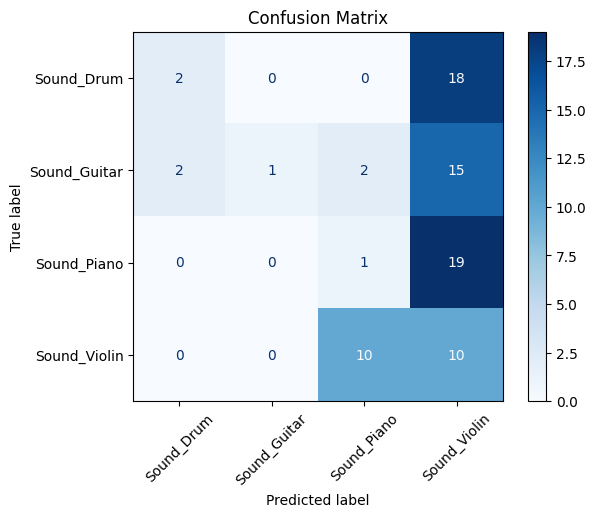

In [44]:
def evaluate(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spectrograms, labels in test_loader:
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            outputs = model(mel_spectrograms)
            _, predicted = torch.max(outputs, 1)

            # Track overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Evaluate on test set
evaluate(model, test_loader, device, dataset['train'].features['label'].names)

In [45]:
torch.save(model, 'fourth_idea.pth')